# Loading data

In [ ]:
import pandas as pd
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

     |████████████████████████████████| 1.1MB 7.1MB/s 
     |████████████████████████████████| 1.1MB 39.4MB/s 
     |████████████████████████████████| 890kB 42.4MB/s 
     |████████████████████████████████| 3.0MB 40.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c6933060f4dfc5790d71b3b8f7550da33a4afc0b63345fb34326a2db8be71656
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/SDG/project/sdg-codebase

Mounted at /content/drive
/content/drive/My Drive/SDG/project/sdg-codebase


In [ ]:
def read_data():
  return pd.read_csv("data/rainmaking_impact_1_label.csv")

data = read_data()
data.shape

(2345, 11)

In [ ]:
data.head()

,Unnamed: 0,Company,Website,Source,Description,Location,SDG Goal,five Ps,Rainmaking SDG Subtopic,Impact Statement,Location of Impact
0,0,10Power,http://10pwr.com/,Rainmaking,10Power provides project development and finan...,USA,7,Prosperity,7.1 Energy Access Solutions,To provide project development and finance for...,United States of America
1,1,1Efficiency,1efficiency.com,Rainmaking,1Efficiency offers an integrated suite of cust...,USA,7,Prosperity,7.4 Energy Enablers,Energy management suite,United States of America
2,2,21CC Education,21cceducation.com,Rainmaking,21CC's offers courses for mid and higher level...,Netherlands,9,Prosperity,9.1 Innovative Logistics,21CC Recruitment & Training - Careers & Learni...,Netherlands/India/USA/Thailand
3,3,24SEA,24sea.eu,Rainmaking,24SEA provides a suite of solutions for monito...,Belgium,7,Prosperity,7.1 Energy Access Solutions,Offshore monitoring and engineering service pr...,Belgium
4,4,3B Ventures,https://3bvc.com,Rainmaking,3B Ventures is an early stage impact fund inve...,Malaysia,9,Prosperity,9.4 Data-based SME financing for developing ma...,Provider of AI consulting and data analytics s...,Denmark


In [ ]:
data['SDG Goal'].value_counts()

7     578
2     359
3     227
1     215
9     160
12    135
13    131
4      87
16     78
8      74
14     54
6      49
11     47
10     45
5      41
17     34
15     31
Name: SDG Goal, dtype: int64

In [ ]:
data['five Ps'].value_counts()

Prosperity      1039
People           978
Planet           216
Peace             78
Partnerships      34
Name: five Ps, dtype: int64

# plot metrics

In [ ]:
def plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose=False):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  if verbose:
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

  return accuracy

In [ ]:
def plotConfusionMatrix(y_test, y_pred, labels):
  cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=labels, 
        yticklabels=labels, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
def plotRocPrecRecallCurve(y_test, predicted_prob, labels):
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  ## Plot roc
  for i in range(len(labels)):
      fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                metrics.auc(fpr, tpr),)
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(labels)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

In [ ]:
def SDGToFivePs(x):
  x = int(x.replace("_goal",""))
  if x in range(0,7):
    return 'People'
  if x in range(13,16):
    return 'Planet'
  if x in range(7,13):
    return 'Prosperity'
  if x in range(16,17):
    return 'Peace'
  if x in range(17,18):
    return 'Partnerships'
  return None

# Model

In [ ]:
class SDGModel(torch.nn.Module):
  def __init__(self, output_size):
    super(SDGModel, self).__init__()
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.bert = BertModel.from_pretrained('bert-base-uncased')
#     for index, param in enumerate(self.bert.parameters()):
#         print(index, param.shape)
#         param.requires_grad = False
    self.out1 = torch.nn.Linear(768, 400)
    self.drop = torch.nn.Dropout(0.5)
    self.out2 = torch.nn.Linear(400, output_size)

  def forward(self, text):
    tokenized_text = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens]).cuda()
    
    if tokens_tensor.shape[1] > 500:
      tokens_tensor = tokens_tensor[0][0:500].unsqueeze(0)
    outputs = self.bert(tokens_tensor)[0]
    o = torch.nn.ReLU()(self.out1(outputs[0][0]))
    o = self.drop(o)
    return self.out2(o)


In [ ]:
from sklearn import metrics
import seaborn as sns
import numpy as np

def evaluate_mode(X_test, model, verbose=True):

  model.eval()
  errors = []

  #eval
  with torch.no_grad():
      y_pred = []
      predicted_prob = []
      y_test = X_test["Target"]
      for index, instance in X_test.iterrows():
          out = model(instance["Description"].lower())
          norm = abs(min(out))+out
          probs = [x/sum(norm).item() for x in norm.tolist()]
          predicted_prob.append(probs)
          y_pred.append(labels[torch.argmax(out).item()])
          # collect companies with errors
          if instance['Target'] != labels[torch.argmax(out).item()]:
            errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
      model.train()

  predicted_prob = np.array(predicted_prob)

  ## plot Accuracy, Precision, Recall
  accuracy = plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose)
      
  ## Plot confusion matrix
  plotConfusionMatrix(y_test, y_pred, labels)

  ## Plot roc, precision recall curve
  if verbose:
    plotRocPrecRecallCurve(y_test, predicted_prob, labels)

  return errors[:5], accuracy

In [ ]:
# def evaluate_mode(test_data, model):
#     model.eval()
#     errors = []
#     with torch.no_grad():
#         y_pred = []
#         y_test = test_data["Target"]
#         for index, instance in test_data.iterrows():
#             out = model(instance["Description"].lower())
#             y_pred.append(labels[torch.argmax(out).item()])
#             # collect companies with errors
#             if instance['Target'] != labels[torch.argmax(out).item()]:
#               errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
#         model.train()
#         return confusion_matrix(y_test, y_pred, labels=labels), accuracy_score(y_test, y_pred), errors


# All Goals

##Predict Five Ps from all goals

In [ ]:
data = read_data()
data.shape

(2345, 11)

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']
1993 1993
352 352
Int64Index([414, 1545, 1311, 929, 1719], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

Prosperity      897
People          817
Planet          180
Peace            69
Partnerships     30
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

People          161
Prosperity      142
Planet           36
Peace             9
Partnerships      4
Name: Target, dtype: int64

In [ ]:
# model = SDGModel(len(labels)).cuda()
model = torch.load("models/allGoalsTo5Ps3.net")

In [ ]:
model("Hello World")
# model.train()

tensor([ 1.0489,  2.1889, -1.8133, -1.9867, -2.2799], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

1993
Epoch=1, index=390, loss=0.0003744508144639743
Peace --> Peace
Epoch=1, index=0, loss=0.0029968401894924076
Prosperity --> Prosperity
Epoch=1, index=1590, loss=0.00215074617396264
Prosperity --> Prosperity
Epoch=1, index=90, loss=0.0037730671511477945
Partnerships --> Partnerships
Epoch=1, index=1800, loss=0.001525555863857638
Planet --> Planet
Epoch=1, index=2130, loss=2.4016144258591036e-05
People --> People
Epoch=1, index=510, loss=0.0012661268021474826
Prosperity --> Prosperity
Epoch=1, index=930, loss=0.0024583614458000133
People --> People
Epoch=1, index=690, loss=0.39313451557691226
People --> People
Epoch=1, index=360, loss=0.13549953845504206
Planet --> Planet
Epoch=1, index=1170, loss=0.1473639614103983
People --> People
Epoch=1, index=150, loss=0.00503066215387662
People --> People
Epoch=1, index=1620, loss=0.005947353258064444
Prosperity --> Prosperity
Epoch=1, index=870, loss=0.0036359991742453226
Prosperity --> Prosperity
Epoch=1, index=300, loss=0.000308584028486317

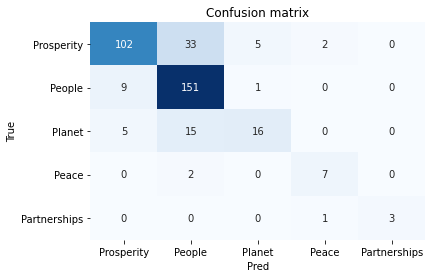

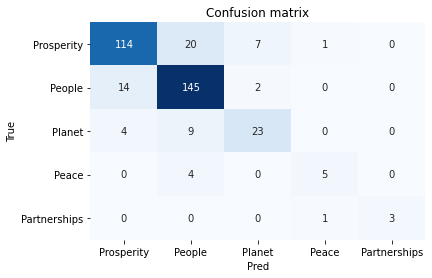

In [ ]:
import time

n_epochs = 2

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model, False)
  print(error)
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.82
Auc: 0.34
Detail:
              precision    recall  f1-score   support

Partnerships       1.00      0.75      0.86         4
       Peace       0.71      0.56      0.63         9
      People       0.81      0.90      0.86       161
      Planet       0.72      0.64      0.68        36
  Prosperity       0.86      0.80      0.83       142

    accuracy                           0.82       352
   macro avg       0.82      0.73      0.77       352
weighted avg       0.82      0.82      0.82       352



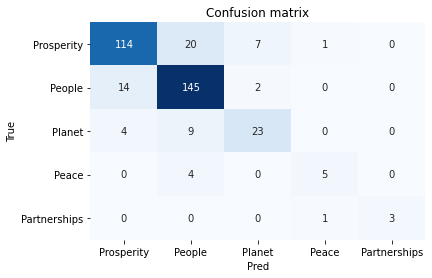

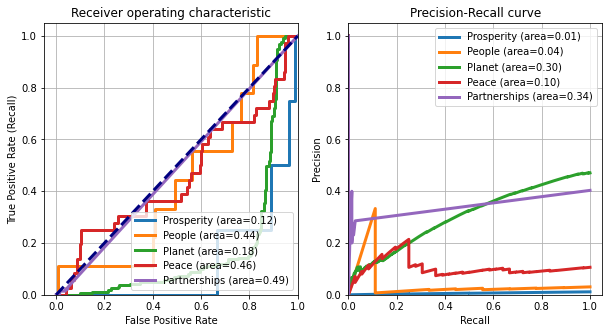

([('Polarstern', 'People', 'Prosperity'),
  ('Claro Energy', 'People', 'Prosperity'),
  ('Wuabi', 'People', 'Prosperity'),
  ('Biochar Central', 'Planet', 'People'),
  ('Reforestum', 'Planet', 'People')],
 0.8238636363636364)

In [ ]:
evaluate_mode(X_test, model)

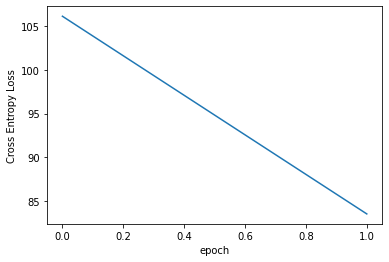

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
# errors

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.8082386363636364


[0.7926136363636364, 0.8238636363636364]

In [ ]:
# Be careful to overwrite our original name file!
# model_name = 'models/allGoalsTo5Ps3.net'

In [ ]:
# torch.save(model,model_name)

In [ ]:
# model = torch.load(model_name)
# model.eval()

##Predict Goals from all goals

In [ ]:
data = read_data()
data.shape

(2345, 11)

In [ ]:
data['Target'] = data['SDG Goal']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

[7, 2, 3, 1, 9, 12, 13, 4, 16, 8, 14, 6, 11, 10, 5, 17, 15]
1993 1993
352 352
Int64Index([414, 1545, 1311, 929, 1719], dtype='int64')


In [ ]:
X_test['Target'].value_counts()

7     81
2     61
1     42
3     38
9     29
13    19
14    14
12    12
8     10
16     9
4      9
11     8
5      6
6      5
17     4
15     3
10     2
Name: Target, dtype: int64

In [ ]:
# model = SDGModel(len(labels)).cuda()
model = torch.load("models/allGoalsToGoals3.net")

In [ ]:
model("Hello World")

tensor([-1.6167, -3.5814, -1.6837, -4.5188, -1.7281, -0.7586, -1.9893, -2.7074,
        -2.9087, -0.0385, -3.4764, -2.2507, -1.1086, -0.5730, -2.4578,  1.3465,
        -3.7727], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

n_epochs = 7

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss/len(curr_data)}")
  losses.append(curr_loss)
  errors.append(error)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

1993
Epoch=1, index=1470, loss=0.024283956550546767
12 --> 12
Epoch=1, index=690, loss=0.001878121523138058
1 --> 1
Epoch=1, index=2160, loss=0.023430884207967514
3 --> 3
Epoch=1, index=2310, loss=0.0006091324466979131
4 --> 4
Epoch=1, index=1080, loss=0.005896886017823514
5 --> 5
Epoch=1, index=0, loss=0.017175058327575245
7 --> 7
Epoch=1, index=900, loss=0.00044726099828646206
7 --> 7
Epoch=1, index=1620, loss=0.00017295782575577808
9 --> 9
Epoch=1, index=1020, loss=0.001272581632899043
2 --> 2
Epoch=1, index=660, loss=0.011760511679070381
7 --> 7
Epoch=1, index=360, loss=0.0008840598230866211
13 --> 13
Epoch=1, index=1170, loss=0.004719986457833632
1 --> 1
Epoch=1, index=1230, loss=0.0012614887493934172
12 --> 12
Epoch=1, index=990, loss=0.005057089045355193
2 --> 2
Epoch=1, index=2010, loss=0.000338478740498734
12 --> 12
Epoch=1, index=1890, loss=0.002076201945358965
2 --> 2
Epoch=1, index=570, loss=0.008890964835518388
2 --> 2
Epoch=1, index=60, loss=0.32142231487559914
2 --> 2
Ep

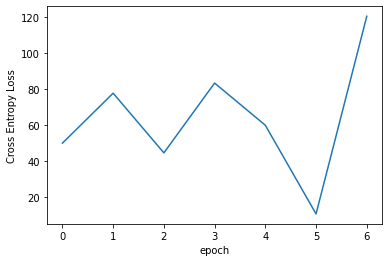

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
errors

[(array([[71,  0,  1,  0,  1,  0,  7,  0,  0,  0,  0,  0,  1,  0,  0,  0,
           0],
         [ 4, 54,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
           0],
         [ 3,  1, 29,  0,  2,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  0,
           0],
         [ 0,  0,  0, 30,  6,  1,  0,  0,  1,  1,  0,  0,  0,  2,  0,  0,
           1],
         [11,  0,  2,  1,  7,  3,  3,  1,  0,  0,  0,  0,  0,  0,  0,  1,
           0],
         [ 1,  3,  0,  0,  0,  7,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 0,  1,  1,  0,  1,  2, 10,  0,  0,  0,  1,  0,  3,  0,  0,  0,
           0],
         [ 0,  0,  1,  1,  0,  0,  0,  6,  0,  1,  0,  0,  0,  0,  0,  0,
           0],
         [ 0,  0,  0,  1,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 0,  1,  0,  0,  0,  2,  0,  0,  0,  5,  0,  0,  0,  0,  1,  1,
           0],
         [ 0,  0,  0,  0,  2,  1,  1,  0,  0,  0,  9,  1,  0,  0,  0,  0,
           0],
         [ 1,  0,  0,

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.7155032467532468


[0.7159090909090909,
 0.7073863636363636,
 0.7017045454545454,
 0.7301136363636364,
 0.7073863636363636,
 0.7244318181818182,
 0.7215909090909091]

In [ ]:
# Be careful to overwrite our original name file!
# model_name = 'models/allGoalsToGoals3.net'

In [ ]:
# torch.save(model,model_name)

# Top N Goals

In [ ]:
# Configuration

N = 7
n_epochs = 30

def readDataAndselectTopGoals(N):
  data = read_data()
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]


##Predict Five Ps from Top N goals

In [ ]:
data = readDataAndselectTopGoals(N)
data.shape

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

In [ ]:
data['Target'].value_counts()

Prosperity    292
People        285
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

In [ ]:
model = SDGModel(len(labels)).cuda()

In [ ]:
model("Hello World")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
evaluate_mode(X_test, model)

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
scores

##Predict Goals from Top N goals

In [ ]:
data = readDataAndselectTopGoals(N)
data.shape

In [ ]:
data['Target'] = data['SDG Goal']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

In [ ]:
X_test['Target'].value_counts()

In [ ]:
model = SDGModel(len(labels)).cuda()

In [ ]:
model("Hello World")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
evaluate_mode(X_test, model)

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
scores

# down sample all goals to 5Ps

##Predict Five Ps from all goals - down sample

In [ ]:
data = read_data()
data['Target'] = data['five Ps']
data.shape

(878, 6)

In [ ]:
data['five Ps'].value_counts()

People          386
Prosperity      359
Planet           77
Peace            34
Partnerships     22
Name: five Ps, dtype: int64

In [ ]:
## each label with 20 samples (as the min)

# g = data.groupby('five Ps')
# # data = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
# X_train = g.apply(lambda x: x.sample(20, random_state=42)).reset_index(drop=True)
# X_train['five Ps'].value_counts()

In [ ]:
# closer down data sample to actual distribution

labels = list(data['Target'].value_counts().keys().values)
counts = [60,50,40,30,20]
X_train = data[data['About'] == '#']

X_train = pd.concat([data[data['Target'] == label].sample(count, random_state=42) for label,count in zip(labels, counts)])
X_train = X_train.sample(frac=1, random_state=42)
print(X_train.index[:5])
X_train['Target'].value_counts()

Int64Index([267, 636, 860, 844, 401], dtype='int64')


People          60
Prosperity      50
Planet          40
Peace           30
Partnerships    20
Name: Target, dtype: int64

In [ ]:
print(X_train.shape)
print(data.shape)
union = pd.merge(data, X_train, how='outer', indicator=True)
X_test = union[union['_merge'] == 'left_only']
X_test.drop('_merge', axis=1, inplace=True)
print(X_test.shape)
X_test['Target'].value_counts()

(200, 6)
(878, 6)
(678, 6)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


People          326
Prosperity      309
Planet           37
Peace             4
Partnerships      2
Name: Target, dtype: int64

In [ ]:
print(labels)

['People', 'Prosperity', 'Planet', 'Peace', 'Partnerships']


In [ ]:
model = SDGModel(len(labels)).cuda()
# model = torch.load("models/allGoalsTo5Ps.net")

In [ ]:
model("Hello World")
# model.train()

tensor([ 0.1929, -0.0092, -0.0877,  0.1151,  0.2819], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

n_epochs = 30

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss/len(curr_data)}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

200
Epoch=1, index=120, loss=0.8567104021708171
People --> People
Epoch=1, index=600, loss=2.497752809524536
Prosperity --> People
Epoch=1, index=420, loss=0.05579948822657267
Peace --> People
Epoch=1, index=30, loss=0.327201243241628
People --> Prosperity
Epoch=1, index=780, loss=1.644852372010549
Prosperity --> People
Epoch=1, index=270, loss=1.1008774479230246
Prosperity --> Prosperity
Epoch=1, index=0, loss=0.15683356523513795
People --> Prosperity
Epoch=1, index=630, loss=0.40747660398483276
Prosperity --> Prosperity
Epoch=1, index=450, loss=2.3866314967473348
Partnerships --> People
(array([[229,  97,   0,   0,   0],
       [121, 188,   0,   0,   0],
       [  8,  29,   0,   0,   0],
       [  1,   3,   0,   0,   0],
       [  2,   0,   0,   0,   0]]), 0.6150442477876106, [('briteforcesoftware.com', 'People', 'Prosperity'), ('civiguard.com', 'People', 'Prosperity'), ('complete-em.com', 'People', 'Prosperity'), ('crisistrack.com', 'People', 'Prosperity'), ('crisisworks.com.au', 'P

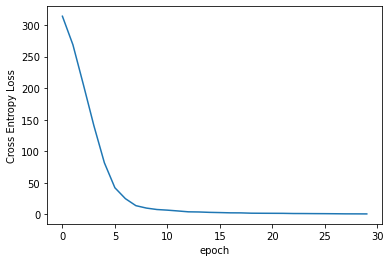

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.4755784061696658


[0.4781491002570694,
 0.480719794344473,
 0.4781491002570694,
 0.4845758354755784,
 0.480719794344473,
 0.480719794344473,
 0.4665809768637532,
 0.4704370179948586,
 0.4794344473007712,
 0.4845758354755784,
 0.480719794344473,
 0.4781491002570694,
 0.4755784061696658,
 0.4640102827763496,
 0.4755784061696658]

In [ ]:
# Be careful to overwrite our original name file!
model_name = 'models/downSampleAllGoalsTo5Ps.net'

In [ ]:
torch.save(model,model_name)

In [ ]:
# model = torch.load(model_name)
# model.eval()

##Predict Five Ps from all goals - down sample with chosen labels

In [ ]:
data = pd.read_csv("data/5Ps_multi_label_to_1_rare.csv")
data['Target'] = data['five Ps']
data.shape

(921, 6)

In [ ]:
data['five Ps'].value_counts()

People          386
Prosperity      359
Planet           77
Partnerships     58
Peace            41
Name: five Ps, dtype: int64

In [ ]:
# labels = list(data['Target'].value_counts().keys().values)
# counts = [110,100,70,45,30]
# X_train = data[data['About'] == '#']

# X_train = pd.concat([data[data['Target'] == label].sample(count, random_state=42) for label,count in zip(labels, counts)])
# X_train = X_train.sample(frac=1, random_state=42)
# print(X_train.index[:5])
# X_train['Target'].value_counts()

Int64Index([379, 808, 392, 728, 855], dtype='int64')


People          110
Prosperity      100
Planet           70
Partnerships     45
Peace            30
Name: Target, dtype: int64

In [ ]:
# g = data.groupby('five Ps')
# # data = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
# X_train = g.apply(lambda x: x.sample(20, random_state=42)).reset_index(drop=True)
# X_train['five Ps'].value_counts()

In [ ]:
# print(X_train.shape)
# print(data.shape)
# union = pd.merge(data, X_train, how='outer', indicator=True)
# X_test = union[union['_merge'] == 'left_only']
# X_test.drop('_merge', axis=1, inplace=True)
# print(X_test.shape)
# X_test['Target'].value_counts()

(355, 6)
(941, 6)
(586, 6)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


People          276
Prosperity      259
Planet           27
Partnerships     13
Peace            11
Name: Target, dtype: int64

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

['People', 'Prosperity', 'Planet', 'Partnerships', 'Peace']
782 782
139 139
Int64Index([790, 65, 847, 896, 613], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

People          329
Prosperity      300
Planet           69
Partnerships     49
Peace            35
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

Prosperity      59
People          57
Partnerships     9
Planet           8
Peace            6
Name: Target, dtype: int64

In [ ]:
model = SDGModel(len(labels)).cuda()
# model = torch.load("models/allGoalsTo5Ps.net")

In [ ]:
model("Hello World")
# model.train()

tensor([-0.1365,  0.0777, -0.0872, -0.1266,  0.1662], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

n_epochs = 15

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss/len(curr_data)}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

782
Epoch=1, index=540, loss=0.9952761610349019
Prosperity --> Planet
Epoch=1, index=420, loss=1.283293225367864
Peace --> People
Epoch=1, index=600, loss=0.944774729013443
Prosperity --> Prosperity
Epoch=1, index=750, loss=0.5819103439648946
People --> Prosperity
Epoch=1, index=90, loss=0.765131672223409
Prosperity --> Prosperity
Epoch=1, index=270, loss=0.16294524272282918
Prosperity --> Prosperity
Epoch=1, index=240, loss=0.5553233087062835
Prosperity --> Prosperity
Epoch=1, index=660, loss=0.6033887684345245
Prosperity --> Prosperity
Epoch=1, index=630, loss=1.8107290426890055
Prosperity --> Prosperity
Epoch=1, index=720, loss=0.5335081120332082
People --> People
Epoch=1, index=870, loss=4.201351767778396
People --> People
Epoch=1, index=510, loss=2.284198143084844
Prosperity --> Prosperity
Epoch=1, index=480, loss=0.9466418266296387
People --> Prosperity
Epoch=1, index=330, loss=0.06416054566701253
Prosperity --> Prosperity
Epoch=1, index=780, loss=2.0253473445773125
Prosperity --

KeyboardInterrupt: ignored

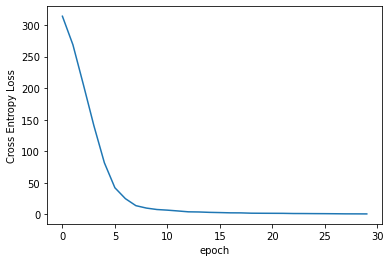

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.4755784061696658


[0.4781491002570694,
 0.480719794344473,
 0.4781491002570694,
 0.4845758354755784,
 0.480719794344473,
 0.480719794344473,
 0.4665809768637532,
 0.4704370179948586,
 0.4794344473007712,
 0.4845758354755784,
 0.480719794344473,
 0.4781491002570694,
 0.4755784061696658,
 0.4640102827763496,
 0.4755784061696658]

In [ ]:
# Be careful to overwrite our original name file!
model_name = 'models/downSampleAllGoalsTo5Ps.net'

In [ ]:
torch.save(model,model_name)

In [ ]:
# model = torch.load(model_name)
# model.eval()